# Learning $\hat{\Omega}$

In this notebook, we're going to demonstrate parameter inference for $\Omega$, under the assumption that $\Omega$ depends only on subgroup sizes within each edge. We consider a scenario in which we already know or have a guess about $Z$. 

In [1]:
using StatsBase
using Combinatorics
using Plots

using Pkg; Pkg.activate(".")
using HypergraphModularity

 Activating environment at `~/hypergraph_modularities_code/Project.toml`


First thing we'll do is define a set of parameters, including group memberships $Z$, degree parameters $\vartheta$, and the connection function $\Omega$. 

In [2]:
# parameters

n = 100
Z = rand(1:2, n)
ϑ = dropdims(ones(1,n) + rand(1,n), dims = 1)

# defining group intensity function Ω
μ = mean(ϑ)

ω(p,α) = (5 .*μ*sum(p))^(-sum(p))*prod(p.^α)^(1/(sum(p)*α))
α0 = 1

kmax = 4

Ω = buildΩ(ω, α0, kmax)

(::HypergraphModularity.var"#Ω#8"{HypergraphModularity.var"#Ω#3#9"{typeof(ω),Int64}}) (generic function with 1 method)

Now we'll sample from the HSBM with these parameters

In [3]:
# sample from the HSBM with these parameters, restricting to hyperedges of size no more than kmax
H = sampleSBM(Z, ϑ, Ω; α=α0, kmax=kmax, kmin = 1)

hypergraph
  N: Array{Int64}((100,)) [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
  E: Dict{Int64,Dict}
  D: Array{Int64}((100,)) [50, 38, 67, 44, 54, 49, 42, 54, 31, 37  …  42, 42, 28, 43, 37, 39, 65, 58, 40, 57]


In [4]:
Ω̂ = estimateΩEmpirically(H, Z; min_val=0)

ϑ̂ = 1.0*[H.D[i] for i in 1:length(H.D)];

Now we can sample from the HSBM with the inferred parameters.

In [5]:
H_ = sampleSBM(Z, ϑ̂, Ω̂; α=α0, kmax=kmax, kmin = 1)

hypergraph
  N: Array{Int64}((100,)) [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
  E: Dict{Int64,Dict}
  D: Array{Int64}((100,)) [53, 44, 49, 33, 50, 58, 35, 46, 31, 42  …  42, 51, 29, 42, 38, 38, 80, 64, 37, 47]


In general, because of the identifiability issues between $\Omega$ and $\vartheta$, we shouldn't expect that $\hat{\Omega}$ is close to $\Omega$ or that $\hat{\vartheta}$ is close to $\vartheta$. However, we can reasonably expect that the associated distributions over hypergraphs are reasonably similar. We can illustrate that heuristically by comparing the degree and dimension sequences. 

In [6]:
d  = [H.D[i] for i in 1:length(H.D)]
d_ = [H_.D[i] for i in 1:length(H_.D)];

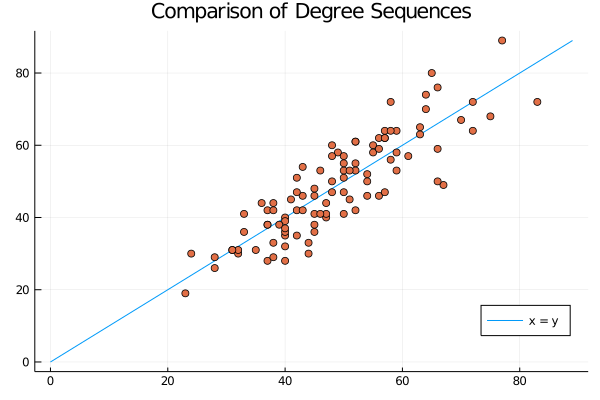

In [7]:
plot([0, maximum(d_)], [0, maximum(d_)], label= "x = y")
plot!(d, d_, seriestype = :scatter,label="", title = "Comparison of Degree Sequences", legend=:bottomright)

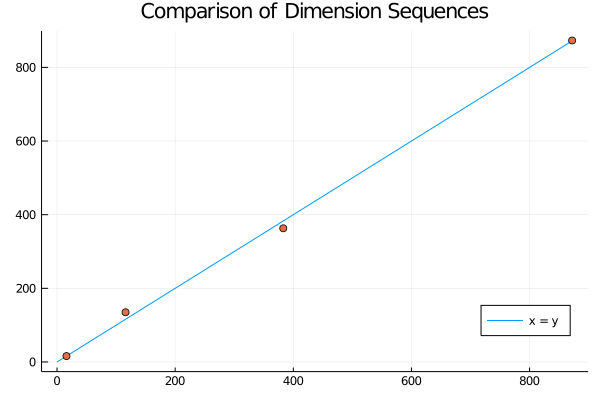

In [8]:
K  = [length(H.E[k]) for k in 1:maximum(keys(H.E))]
K_ = [length(H_.E[k]) for k in 1:maximum(keys(H_.E))]

plot([0, maximum(K_)], [0, maximum(K_)], label= "x = y")
plot!(K, K_, seriestype = :scatter,label="", title = "Comparison of Dimension Sequences", legend=:bottomright)

This is reasonable qualitative evidence that we are able to correctly learn $\Omega$ from data in this restricted case. 